# Create a deconvolved stellar template

## Background

Before modelling observations of the star to extract RVs, we need to create a high-S/N stellar template to use in the observation modelling.

What you need for this:

- observation spectra of hot stars, typically of spectral type O or B, which do not show any spectral features in the I2 wavelength range between ~ 5000 -- 6000 Å, obtained *with* the I2 cell in the light path; the recorded spectra then basically only consist of the I2 features, and can be used to determine the LSF of the instrument;

- observation spectra of the star of interest *without* any I2 absorption features, taken inbetween the O/B-star spectra.

So in the template creation we first model the sum of all O/B-star spectra $I_\mathrm{O/B}$ from a combination of a flat continuum and the I2 template spectrum $T_\mathrm{I2}(\lambda)$, convolved by a model of the LSF $L(x)$ and multiplied by a continuum model $k(x)$:

$$
    \hat{I}_\mathrm{O/B}(x) = k(x) \cdot T_\mathrm{I2}\big(\lambda(x)\big) * L(x)
$$

This is done in small chunks of the whole spectrum ($\sim 2 \,Å$ in length) to reduce complexity. From this we receive a good guess of the LSF of the instrument for each chunk. We assume that the LSF is fairly stable over the short time difference lying between the observations of the O/B-stars and our target star, so we can use the results now to deconvolve the summed up target star spectra and end up with a deconvolved, high-S/N stellar template spectrum of that star (again in chunks). (More on this you find e.g. in [Butler et al. (1996)](https://ui.adsabs.harvard.edu/abs/1996PASP..108..500B/abstract/))

## Run the code

But **pyodine** allows you to create the template without having to know exactly how it works. First, we need to set up the path and import the required pyodine modules:

In [6]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('/home/paul/pyodine/')  # Put in the pyodine path on your machine here!

import pyodine
import pyodine_create_templates         # <- the template creation routines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Also, we import the utilities module for the instrument we are working with - in this case for SONG. It contains all the instrument-specific code, particularly routines to import the spectra from `fits`-format along with useful information from the `fits`-headers. Upon import we call the SONG-specific ``utilities_song`` simply ``utilities``:

In [7]:
import utilities_song as utilities

Additionally, a parameter input object of type ``Template_Parameters`` is needed. It contains all the instrument-specific parameters such as oversampling used in the modelling, how to chunk up the spectra, and also the exact definition of the workflow for the analysis routine. By default, there should be a module called ``pyodine_parameters`` within each ``utilities`` module, but you could also create a different one and import it if you wish to experiment with changing parameters. However, we will stick with the well-tested default parameters for SONG here:

In [8]:
Pars = utilities.pyodine_parameters.Template_Parameters()

Finally, we need to define the pathnames to the observations of the O-star with I2, and to the observations of the star without I2. We simply collect them from the respective directories of the tutorial data. Also, we define the output pathname for the deconvolved template, the directory name where to save analysis plots, and the output pathnames of the collected results. In our analysis, we model the O-star data in two runs (first with a Single-Gaussian LSF to establish good parameter guesses, and then with the final Multi-Gaussian LSF), and we save the results from both runs - the first as '.h5' (HDF5 format), the second as '.pkl' (through the **dill** Python package).

In [9]:
# O-star observations to use for the modelling
ostar_dir   = '/home/paul/data_song/data_ext/sigdra_template/2018-05-16/obs_ostar'
ostar_files = [os.path.join(ostar_dir, f) for f in os.listdir(ostar_dir)]
ostar_files.sort()

# Stellar observations to use for the deconvolution
temp_dir   = '/home/paul/data_song/data_ext/sigdra_template/2018-05-16/obs_temp'
temp_files = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir)]
temp_files.sort()

# Output pathname for the template
temp_outname = '/home/paul/data_song2/templates/temp_sigdra_2018-05-16.h5'

# Output directory for plots and pathnames for modelling results
plot_dir  = '/home/paul/data_song2/data_res/sigdra_temp/'
res_files = [os.path.join(plot_dir, 'sigdra_2018-05-16_res0.h5'),
             os.path.join(plot_dir, 'sigdra_2018-05-16_res1.pkl')]

# Log files
error_file = os.path.join(plot_dir, 'error.log')
info_file  = os.path.join(plot_dir, 'info.log')

And now, we can kick off the template creation:

In [10]:
pyodine_create_templates.create_template(utilities, Pars, ostar_files, temp_files, 
                                         temp_outname, plot_dir=plot_dir, res_files=res_files, 
                                         error_log=error_file, info_log=info_file)

---------------------------
Aiming to create template: /home/paul/data_song2/templates/temp_sigdra_2018-05-16.h5

Orders to use: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]

Velocity guess: 25.136 km/s
Barycentric velocity: 2.026 km/s
Warning! Max. nr. of chunks without cutting down is 21!

Total number of chunks: 528
Chunks per order: 22
First and last covered pixel of chunks: 30, 2031
Orders: 18 - 41

----------------------
RUN 0
----------------------

Constraining parameters for RUN 0


100% (528 of 528) |######################| Elapsed Time: 0:00:23 Time:  0:00:23



Number of chunks with no uncertainties: 0
Number of chunks with outliers: 0
Number of chunks with nan fitted red. Chi2: 0

Creating analysis plots...

----------------------
RUN 1
----------------------

Constraining parameters for RUN 1

Fitted LSF parameters:
<ParameterSet (values: 10)>
    left_1  =  6.491226501145553
    left_2  =  -8.060503954209725
    left_3  =  4.2641949580532925
    left_4  =  -1.4996989286612574
    left_5  =  0.37808604131223594
    right1  =  6.491312875599473
    right2  =  -8.060599340542252
    right3  =  4.264240048195785
    right4  =  -1.499713032073036
    right5  =  0.3780894175194895


100% (528 of 528) |######################| Elapsed Time: 0:02:08 Time:  0:02:08



Number of chunks with no uncertainties: 0
Number of chunks with outliers: 0
Number of chunks with nan fitted red. Chi2: 0

Creating analysis plots...

----------------------
All runs done, continuing to template deconvolution...
Deconvolve: /home/paul/data_song/data_ext/sigdra_template/2018-05-16/obs_temp/s1_2018-05-17T03-15-36_ext.fits
Deconvolving chunks...


100% (528 of 528) |######################| Elapsed Time: 0:02:59 Time:  0:02:59


Saving deconvolved template to /home/paul/data_song2/templates/temp_sigdra_2018-05-16.h5

Done, full working time: 384.5508987903595


Great, everything went fine! Let's have a look at the printed output:

- 3rd row from top, a velocity guess is reported. This has been found by cross-correlation of the template observation spectrum with a reference spectrum (Arcturus or Sun), and in the end this velocity guess ($v_\mathrm{temp}^\mathrm{ref}$) is saved as meta-information to the deconvolved stellar template. Later, when modelling an observation, a first guess of the relative velocity shift between observation and template is found through $v_\mathrm{guess} = v_\mathrm{obs}^\mathrm{ref} - v_\mathrm{temp}^\mathrm{ref}$ (where $v_\mathrm{obs}^\mathrm{ref}$ is the observation velocity guess with respect to the same reference spectrum).

- 5th row from top, a warning is reported. In our parameter file we define to create 22 chunks per order, but given the desired chunk parameters (width, padding, pixel offset), the padding region of the last chunk within each order would extend past the order edges. We do not need to worry though, as the algorithm automatically reduces the padding size of the last chunks to make it fit (the last chunk then only has a padding of 17 pixels instead of 25 as defined in the parameter file)!

- We then see that RUN 0, where we use a Single-Gaussian LSF model, looped quite quickly through all chunks of the O/B-star spectrum. We get some information about fitting success, and you would have to worry if chunks with 'nan fitted red. Chi2' was larger than 0 - this would mean that the fitting had failed for some chunks.

- In RUN 1, we use a Multi-Gaussian LSF model, and to receive good starting parameters for it we fit a Single-Gaussian model, constructed from the median of the RUN 0 best-fit results from all chunks, with the Multi-Gaussian model - the result of that fit is printed under 'Fitted LSF parameters'.

- RUN 1 then takes a bit longer to loop over all chunks than RUN 0 (no wonder due to the more complex model). Again, we see that for no chunks the fitting failed (this is absolutely necessary, as the best-fit results from this run are used in the deconvolution).

- Finally, the deconvolution of the stellar template observation begins, which again takes some time. The deconvolved stellar template is then saved as defined in the input to the function.

## Inspecting the fit results

Alright, let's load the saved results and inspect them - first the results from the second (Multi-Gaussian) run. This is quite straight forward, as they were saved through the **dill** package, where the whole object structure is preserved and can easily be restored:

In [6]:
fit_results_1 = pyodine.fitters.results_io.load_results(res_files[1], filetype='dill')

# Also construct the original chunks array of the O/B-star observations
chunks = pyodine.components.ChunkArray()
for r in fit_results_1:
    chunks.append(r.chunk)

The `fit_results_1` list contains the original fit-results objects for each chunk, along with model and chunk data, which makes it really easy to analyze and work with:

In [7]:
print('Number of chunks/fit results:', len(fit_results_1))
print('\nObject structure of each fit result:')
print(fit_results_1[0].__dict__)

Number of chunks/fit results: 528

Object structure of each fit result:
{'chunk': <pyodine.components.Chunk object at 0x7fb15c51c190>, 'model': <pyodine.models.spectrum.SimpleModel object at 0x7fb15d0359a0>, 'lmfit_result': <lmfit.minimizer.MinimizerResult object at 0x7fb15d035ee0>, 'chunk_ind': 0}


The results from the first run (Single-Gaussian) in contrast we saved in HDF5-format, which is basically just a dictionary of the model results and important meta-information. In order to preserve functionality, **pyodine** comes with a routine `restore_results_object()` that helps restoring the fit-results objects, model and chunks from that saved dictionary (basically by building them from scratch using the dictionary information).

*Important:* As the data of the input spectra is not saved with the results when using the HDF5-format, the observation spectra must be loaded again from the pathnames used in the original modelling. Therefore you also need to hand the correct `utilities` module to the function. *Of course, this only works if the pathnames of the input spectra are still the same!*

In [8]:
chunks, fit_results_0 = pyodine.fitters.results_io.restore_results_object(
    utilities, res_files[0])

Warning! Max. nr. of chunks without cutting down is 21!
Total number of created chunks: 528 (in result file: 528)
Number of created chunks per order: 22


So let's have a look at the results (RUN 1 for now). Always interesting: Checking out some random chunk to see the data along with the best-fit model result for that chunk. This is straight forward, just use the dedicated built-in plotting function:

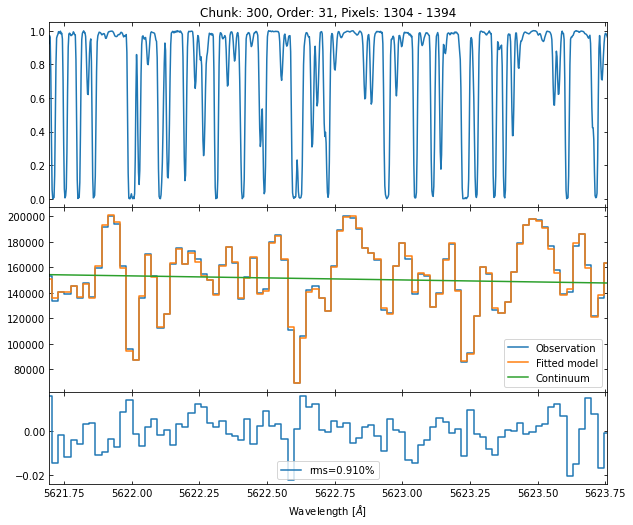

In [9]:
# Chunk index
chunk_ind = 300

pyodine.plot_lib.plot_chunkmodel(fit_results_1, chunks, chunk_ind, template=False, 
                                 show_plot=True)

As you see, mostly the model fits the data quite well, and the rms of the relative residuals is roughly $0.9 \%$.

Next, we can get an impression about the overall modelling success by plotting a histogram of the relative residuals of all chunks - again there is a built-in function for that:

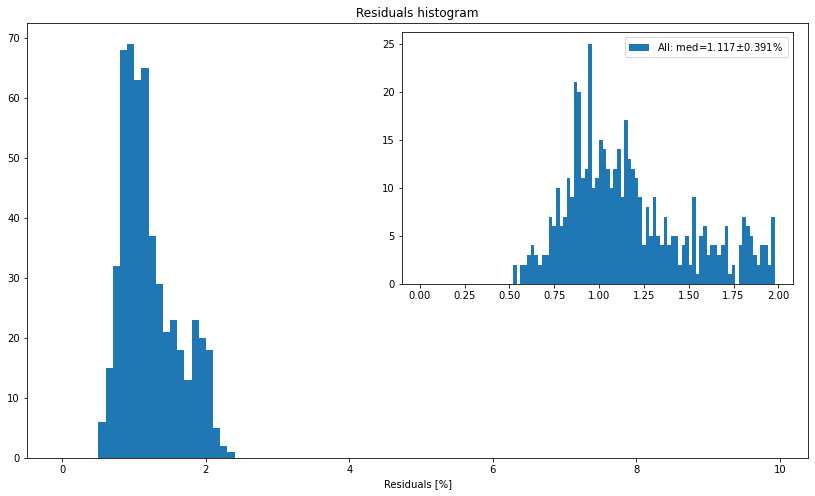

In [10]:
residuals = pyodine.plot_lib.plot_residual_hist(fit_results_1, title='Residuals histogram', 
                                                show_plot=True)

We can see that while most chunks have residuals around $1 \%$, there's a small peak of chunks with residuals around $2 \%$. To find out more, we can also just create a scatter plot of the residuals over all chunks:

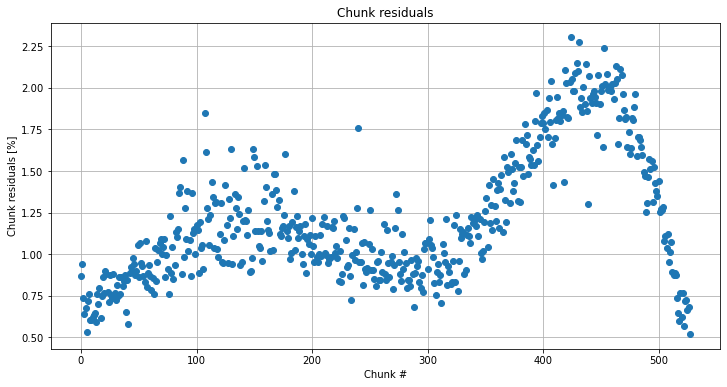

In [11]:
pyodine.plot_lib.plot_chunk_scatter(scatter=residuals, ylabel='Chunk residuals [%]', 
                                    title='Chunk residuals', show_plot=True)

As you can see, at higher indices (redder wavelengths) the chunk residuals go up significantly - this is due to a combination of a fringing effect in the optical path of the SONG telescope and probably also some telluric contamination of the spectra. Still, this is not as bad as it looks and we are still able to receive good RV results!

Also, I'm always intrigued by looking at the actual LSFs. To do so, we must first evaluate them (in the fit results only the best-fit LSF parameters for each chunk are saved). Then, we can use another built-in function for plotting:

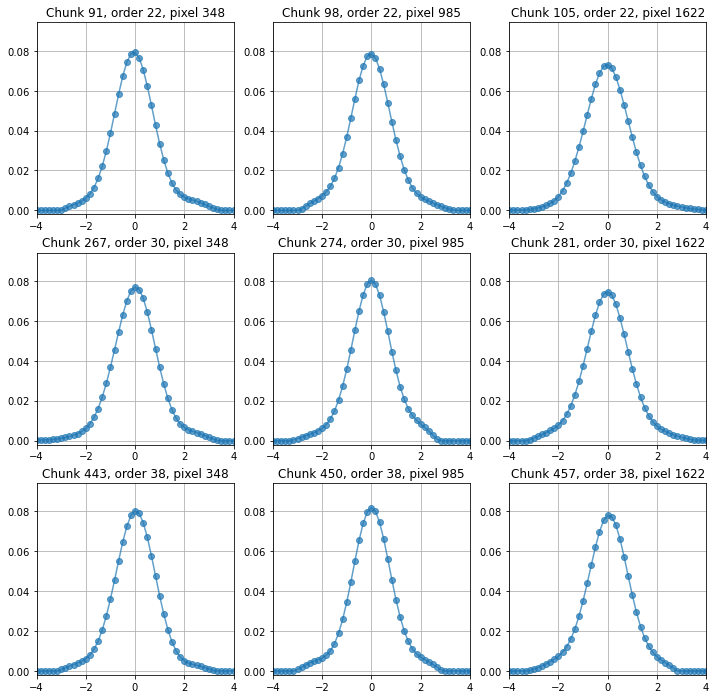

In [12]:
# The LSF model, oversampling and convolution width used
lsf_model      = fit_results_1[0].model.lsf_model
osample_factor = fit_results_1[0].model.osample_factor
conv_width     = fit_results_1[0].model.conv_width

# Generate the pixel vector to evaluate the LSF over
lsf_x = lsf_model.generate_x(osample_factor=osample_factor, conv_width=conv_width)

# Now loop over all chunks, evaluate the LSFs and append them to a list
lsfs = []
for i in range(len(fit_results_1)):
    lsf_pars = fit_results_1[i].params.filter('lsf')
    lsfs.append(lsf_model.eval(lsf_x, lsf_pars))

# Finally plot a grid of 3x3 LSFs
pyodine.plot_lib.plot_lsfs_grid(lsfs, chunks, x_lsf=lsf_x, x_nr=3, y_nr=3, 
                                alpha=0.7, xlim=(-4,4), show_plot=True)

It is obvious that the LSF is generally quite stable spatially - at lower orders and higher pixel numbers the peak is a bit smaller, but the overall shape never changes much.

Finally, let's check out the wavelength model. We can pull the best-fit results for the wavelength slope from all chunks, and compare it to the simple dispersion for each chunk computed by: 

$$
    \delta\lambda = \frac{\lambda_{-1} - \lambda_{0}}{\#_\mathrm{pix}}
$$

where $\lambda_{-1}$ and $\lambda_{0}$ are the wavelengths of the last and first pixel of each chunk, and $\#_\mathrm{pix}$ is the number of pixels in the chunk.

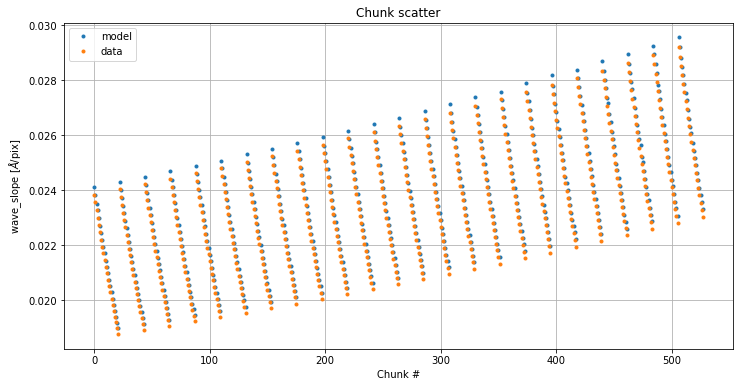

In [13]:
# The best-fit wavelength slopes for all chunks
wave_slopes_model = [r.params['wave_slope'] for r in fit_results_1]
# The estimated dispersion for all chunks (from the original spectrum)
wave_slopes_data = [(ch.wave[-1]-ch.wave[0])/len(ch) for ch in chunks]

pyodine.plot_lib.plot_chunk_scatter(scatter=[wave_slopes_model,wave_slopes_data], 
                                    scatter_fmt='.', scatter_label=['model', 'data'], 
                                    ylabel=r'wave_slope [$\AA$/pix]', show_plot=True)

And now, for completeness sake, let's again look at the same chunk as in the beginning - but using the results from RUN 0. You'll see that the residuals are in fact larger when using the Single-Gaussian LSF:

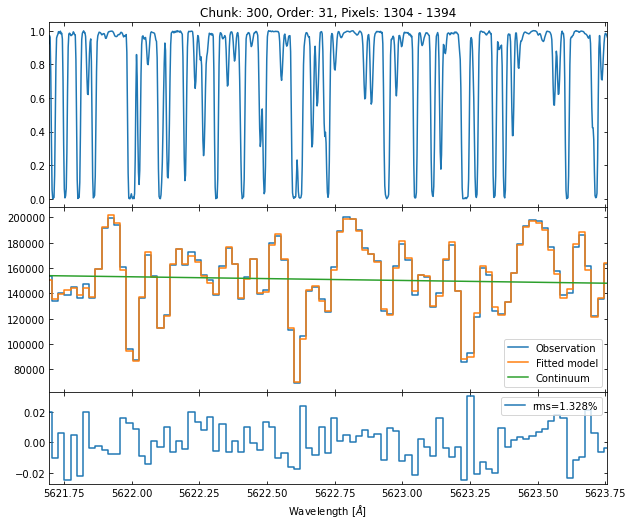

In [14]:
# Chunk index
chunk_ind = 300

pyodine.plot_lib.plot_chunkmodel(fit_results_0, chunks, chunk_ind, template=False, 
                                 show_plot=True)

## Inspecting the deconvolved stellar template

Of course, what we are really interested in is the deconvolved stellar template, as we will use that later when we model observations of the star. So, let's load the deconvolved template from file:

In [15]:
template = pyodine.template.base.StellarTemplate_Chunked(temp_outname)

print('The deconvolved template object:\n', template)
print('\nThe first chunk of the template:\n', template[0])

Loading template from file: /home/paul/data_song2/templates/temp_sigdra_2018-05-16.h5
The deconvolved template object:
 <StellarTemplate_Chunked of HD 185144 (528 chunks, 24 orders)>

The first chunk of the template:
 <Spectrum (1401 pixels, 4993.6009-4996.9754 Å>


The deconvolved template in this form is saved basically as a list of the individual deconvolved chunks, along with some meta-data and information.

We want to compare it to the original stellar template observations that it was deconvolved from, so let's load these observations also:

In [16]:
# First load the individual observations into a list
temp_obs_specs = [utilities.load_pyodine.ObservationWrapper(t) for t in temp_files]

# Now create the summed observation from all individual ones
temp_obs = pyodine.components.SummedObservation(*temp_obs_specs)

And now let us plot a chunk of both - for the summed observation we obviously need to extract exactly the part which corresponds to the template chunk:

Text(0.5, 1.0, 'HD 185144, chunk 301')

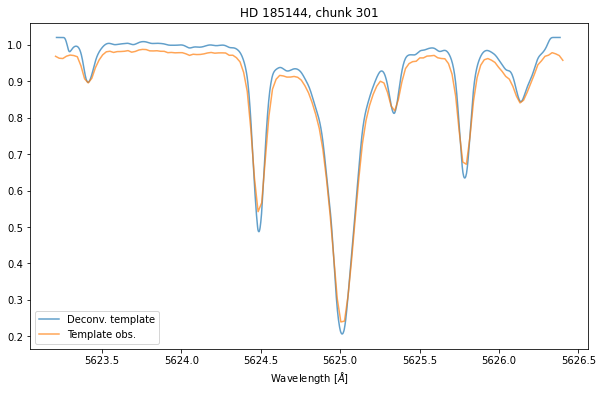

In [17]:
# Chunk index
chunk_ind = 301

# The wavelength range covered by this chunk
wave_range = [template[chunk_ind].wave[0], template[chunk_ind].wave[-1]]

# Load a sub-spectrum of the summed observation covering this range
temp_obs_ch = temp_obs.get_wavelength_range(wave_range[0], wave_range[1])

# And plot
fig = plt.figure(figsize=(10,6))
plt.plot(template[chunk_ind].wave, template[chunk_ind].flux, 
         alpha=0.7, label='Deconv. template')
plt.plot(temp_obs_ch.wave, temp_obs_ch.flux/(temp_obs_ch.cont*3), 
         alpha=0.7, label='Template obs.')
plt.legend()
plt.xlabel(r'Wavelength [$\AA$]')
plt.title('{}, chunk {}'.format(template.starname, chunk_ind))

That's cool, the deconvolved template actually shows deeper, narrower absorption lines than the observation - exactly what we would expect when cleaning a spectrum of the instrumental LSF!